In [1]:
# I - : Importing  the library and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
from keras.models import Model,load_model
from keras import layers,Input
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,make_scorer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.utils import plot_model

In [2]:
# II - : Importing the training set
dataset=pd.read_csv("https://raw.githubusercontent.com/oreilly-mlsec/book-resources/599669c7124dffb65ea7f6e0b7626df32496b1d6/chapter3/datasets/cpu-utilization/cpu-full-b.csv", sep=",")

In [3]:
# III -  split of data Test & Training

# III.1 - : Size the data Test, Training
train_size=int(len(dataset)*.85)
test_size=int(len(dataset)*.15)
x_trainning,x_testing=dataset.iloc[0:train_size],dataset.iloc[(train_size+1):(train_size+test_size)]

In [4]:
# III.3 - : Preparing data for timesteps (lags)

def normalisationPreparationDonnee(data,lags):
    data=data['cpu'].values
    sc = MinMaxScaler(feature_range = (0, 1))
    #sc=StandardScaler()
    data1= data.reshape(-1,1)
    data2 = sc.fit_transform(data1)
    def preparation_data():
        x_train = []
        y_train = []
        for i in range(lags,len(data2)):
            x_train.append(data2[i-lags:i, 0])
            y_train.append(data2[i, 0])
        return np.array(x_train), np.array(y_train)
    x_train, y_train = preparation_data()
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train


In [5]:
# IV - TRAINING OF DIFFERENTS MODELS

lags=5

x_train, y_train = normalisationPreparationDonnee(x_trainning, lags)
x_test, y_test = normalisationPreparationDonnee(x_testing, lags)


In [33]:
# IV.8  Approche par les méthodes hybrides : Auto Encoder - RNN-Bidirectionnel
# data_input=Input(shape=(x_train.shape[1], 1))
start=time()

data_input=Input(shape=(x_train.shape[1], 1))

# extraction des données par un autoencoder

autoencod=layers.LSTM(100,return_sequences=True)(data_input)
autoencod=layers.LSTM(128, return_sequences=True)(autoencod)
autoencod=layers.LSTM(64,return_sequences=True)(autoencod)
autoencod=layers.LSTM(64,return_sequences=True)(autoencod)
autoencod=layers.LSTM(32,return_sequences=False)(autoencod)
autoencod=layers.RepeatVector(x_train.shape[1])(autoencod)
autoencod=layers.LSTM(128,return_sequences=True)(autoencod)
autoencod=layers.LSTM(100,return_sequences=False)(autoencod)

# modeleisation par un GRU : c'est un LSTM optimisé

modGRU=GRU(units = 100, return_sequences = True)(data_input)
modGRU=GRU(units = 128, return_sequences = True)(modGRU)
modGRU=GRU(units = 64, return_sequences = True)(modGRU)
modGRU=GRU(units = 32, return_sequences = True)(modGRU)
modGRU=GRU(units = 64, return_sequences = True)(modGRU)
modGRU=GRU(units = 128, return_sequences = True)(modGRU)
modGRU=GRU(units = 100)(modGRU)

# modelisation par un Bidirectionnel

modelBidir=Bidirectional(LSTM(units = 100, return_sequences = True))(data_input)
modelBidir=Bidirectional(LSTM(units = 64, return_sequences = True))(modelBidir)
modelBidir=Bidirectional(LSTM(units = 32, return_sequences = True))(modelBidir)
modelBidir=Bidirectional(LSTM(units = 64, return_sequences = True))(modelBidir)
modelBidir=Bidirectional(LSTM(units = 128, return_sequences = True))(modelBidir)
modelBidir=Bidirectional(LSTM(units = 100))(modelBidir)

# concatenation des sorties de l'ensemble des differents modèles

modelconcat=layers.concatenate([autoencod,modGRU,modelBidir],axis=-1)

# modelisation des sorties par un reseau dense

modelensembleF=layers.Dense(units = 100,activation='relu')(modelconcat)
modelensembleF=layers.Dense(units = 64,activation='relu')(modelensembleF)
modelensembleF=layers.Dense(units = 1)(modelensembleF)

model=Model(data_input,modelensembleF)

model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
              metrics=['accuracy'])

historymodel=model.fit(x_train, y_train, epochs = 500, batch_size = 5,validation_split=0.20,verbose=0)

elapsed=time()-start
print('durée totale est de(en seconde) :',elapsed)
print('durée totale est de(en minute):',elapsed/60)



durée totale est de(en seconde) : 3504.850453853607
durée totale est de(en minute): 58.41417423089345


In [34]:
elapsed=time()-start
print('durée totale est de(en seconde) :',elapsed)
print('durée totale est de(en minute):',elapsed/60)


durée totale est de(en seconde) : 3504.8874459266663
durée totale est de(en minute): 58.41479076544444


In [35]:
# Enregistrement et importation du modèle
# model.save('modelhybrideProj.h5') 
# model= load_model('modelhybrideProj.h5')
                                                

In [36]:
#  IV.1.4 - : Calculating Errors and Viewing Model Fits
# on Training and Test data(identical reference for all methods)

def ErreurPrediction(Nommodele,data,prediction ):
    print('La R^2-Squared(r2_score) du modèle {} est : {}'.format(Nommodele,r2_score(data,prediction)))
    print('La MAE modèle {} est de: {} '.format(Nommodele,mean_absolute_error(data,prediction)))
    print('La MSE modèle {} est de: {} '.format(Nommodele,mean_squared_error(data,prediction)))
    print('RMSE est:{}'.format(np.sqrt(mean_squared_error(data,prediction))))
   

def LossAccuracy(nomDonnées,modelLSTM,x_test,y_test):
    score = modelLSTM.evaluate(x_test, y_test,verbose=0)
    erreur=modelLSTM.metrics_names
    print('Les pertes sur les données {} sont: '.format(nomDonnées))
    print("%s: %.2f%%" % (erreur[0], score[0]*100))
    print("%s: %.2f%%" % (erreur[1], score[1]*100))


#  IV.1.5 - : Viewing two-by-two graphs

def Affichage(historylstm,modelLSTM,Nommodele):
    y_pred_train=modelLSTM.predict(x_train)
    y_pred_test=modelLSTM.predict(x_test)
    plt.figure(figsize=(18,10))
    plt.subplot(1,3,1)
    plt.plot(historylstm.history['loss'],'b',label='Entrainement')
    plt.plot(historylstm.history['val_loss'],'green',label='Validation')
    plt.title('Perte Modèle {}'.format(Nommodele))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrainement', 'Validation'], loc='upper left')
    plt.subplot(1,3,2)
    plt.plot(y_train, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_train, color = 'blue', label = 'Prédiction du modèle {}'.format(Nommodele))
    plt.title('Modèle {} : Data training'.format(Nommodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(y_test, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_test, color = 'blue', label = 'Prédiction du modèle {} '.format(Nommodele))
    plt.title('Modèle {} :Data test'.format(Nommodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    
def Affichage_Model(modelLSTM,NomDumodele):
    y_pred_train=modelLSTM.predict(x_train)
    y_pred_test=modelLSTM.predict(x_test)
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.plot(y_train, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_train, color = 'blue', label = 'Prédiction du modèle {}'.format(NomDumodele))
    plt.title('Modèle {} : Data training'.format(NomDumodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(y_test, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_test, color = 'blue', label = 'Prédiction du modèle {} '.format(NomDumodele))
    plt.title('Modèle {} :Data Test'.format(NomDumodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()

In [37]:
ErreurPrediction("Erreur données entrainement hybride autoencoder-GRU-Bidir",y_train,model.predict(x_train))
ErreurPrediction("Erreur données test",y_test,model.predict(x_test))

La R^2-Squared(r2_score) du modèle Erreur données entrainement hybride autoencoder-GRU-Bidir est : 0.9722755980031001
La MAE modèle Erreur données entrainement hybride autoencoder-GRU-Bidir est de: 0.026239572136069523 
La MSE modèle Erreur données entrainement hybride autoencoder-GRU-Bidir est de: 0.0017201468701737944 
RMSE est:0.04147465334603527
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.7885518191868041
La MAE modèle Erreur données test est de: 0.08625299272266218 
La MSE modèle Erreur données test est de: 0.016441848434631562 
RMSE est:0.12822577133568572


Les pertes sur les données entrainement sont: 
loss: 0.17%
accuracy: 0.54%
Les pertes sur les données Test sont: 
loss: 1.64%
accuracy: 5.38%


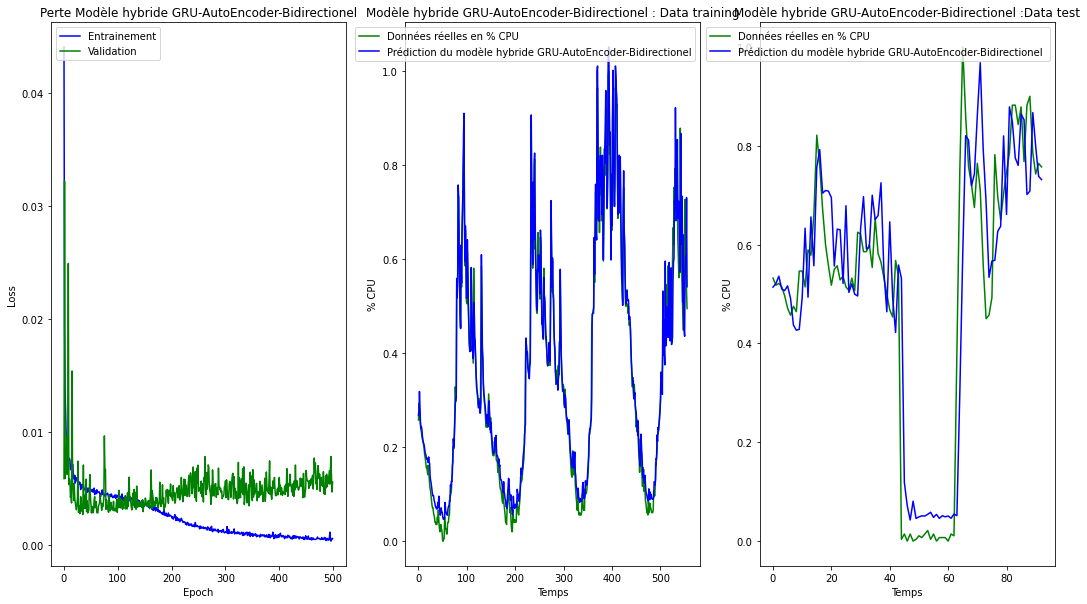

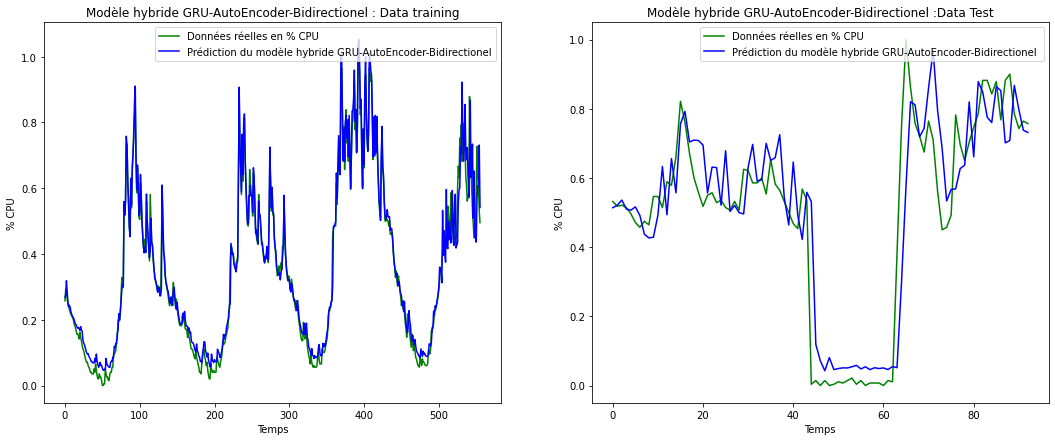

In [38]:
Affichage(historymodel,model,"hybride GRU-AutoEncoder-Bidirectionel")
Affichage_Model(model,"hybride GRU-AutoEncoder-Bidirectionel")
LossAccuracy("entrainement",model,x_train,y_train)
LossAccuracy("Test", model,x_test,y_test)

In [39]:
# Enregistrement et importation du modèle
model.save('modelhybrideProj.h5') 